<a href="https://colab.research.google.com/github/LeNovice/PSW/blob/main/Better_CadenceNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Implementing

Focal Loss:
* https://www.dlology.com/blog/multi-class-classification-with-focal-loss-for-imbalanced-datasets/
* https://github.com/artemmavrin/focal-loss

If we make Data Augmentation as a layer in the model (maybe only for training) then we won't see overfitting on training or validation data 

In [ ]:
USE_ORIGINAL = 0
loss = 'sparse_categorical_crossentropy'

In [ ]:
import tensorflow_datasets as tfds
import numpy as np
#For plotting the dataset
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
#Data pipeline preparation
import tensorflow as tf
from tensorflow.keras import layers
#model building
from tensorflow.keras import models
import tensorflow.keras.utils as tfutils
import os
import copy

In [ ]:
NUM_CLASSES = 10

DataSet = 'caltech101'
#'cifar10'
def num_samples_per_class(ds_train, get_top_10 = False, print_all = False):
    vals = np.unique(np.fromiter(ds_train.map(lambda x, y: y), int), return_counts=True)
    class_list = []
    class_hist = []
    for val,count in zip(*vals):
        if print_all==True:
            print(int(val), count)
        class_hist.append((val,count))
    if get_top_10 == True:
        sorted_tuple = sorted(class_hist, key=lambda t: t[-1], reverse=True)[:(NUM_CLASSES + 1)]    #+1 because we are going to remove "backround_google" i.e. 4
        class_list = [x for x,y in sorted_tuple]
    return class_list

def filter_fn(x, allowed_classes:list):
    allowed_classes = tf.constant(allowed_classes)
    isallowed = tf.equal(allowed_classes, tf.cast(x, allowed_classes.dtype))
    reduced_sum = tf.reduce_sum(tf.cast(isallowed, tf.float32))
    return tf.greater(reduced_sum, tf.constant(0.))

In [ ]:
#ds_train = tfds.load(DataSet, split='train + test[:75%]', as_supervised=True)
ds_train, train_info = tfds.load(DataSet, split='train + test[:75%]', as_supervised=True, with_info = True)
ds_test = tfds.load(DataSet, split='test', as_supervised=True)

In [ ]:
class_list = num_samples_per_class(ds_train, get_top_10=True)
if DataSet == 'caltech101':
  class_list = [i for i in class_list if i != train_info.features['label'].str2int('background_google')]
  class_list.sort()

"""for name in train_info.features['label'].names:
    print(name, train_info.features['label'].str2int(name))
"""

class_names = [train_info.features['label'].int2str(i) for i in class_list]
display(class_names)

['airplanes',
 'bonsai',
 'car_side',
 'faces',
 'faces_easy',
 'hawksbill',
 'ketch',
 'leopards',
 'motorbikes',
 'watch']

In [ ]:
resized_ds_train = ds_train.filter(lambda x, y: filter_fn(y, class_list)) # as_supervised
resized_ds_test = ds_test.filter(lambda x, y: filter_fn(y, class_list))

In [ ]:
num_samples_per_class(resized_ds_train, print_all=True)

1 610
9 103
16 101
37 337
38 333
46 87
54 88
57 155
66 626
95 194


[]

In [ ]:
num_samples_per_class(resized_ds_test, print_all=True)

1 770
9 98
16 93
37 405
38 405
46 70
54 84
57 170
66 768
95 209


[]

In [ ]:
#Hyperparameters
IMG_SIZE = 60
NUM_CHANNELS = 3
BATCH_SIZE=128

input_shape = (IMG_SIZE,IMG_SIZE,NUM_CHANNELS)
#Relabelling to avoid issues. Note that human readability is reduced by this
table = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(
        keys=tf.constant(class_list, dtype=tf.int64),
        #values=tf.constant([tfutils.to_categorical(0, num_classes=NUM_CLASSES, dtype=np.int64), tfutils.to_categorical(1, num_classes=NUM_CLASSES, dtype=np.int64), tfutils.to_categorical(2, num_classes=NUM_CLASSES, dtype=np.int64), tfutils.to_categorical(3, num_classes=NUM_CLASSES, dtype=np.int64), tfutils.to_categorical(4, num_classes=NUM_CLASSES, dtype=np.int64), tfutils.to_categorical(5, num_classes=NUM_CLASSES, dtype=np.int64), tfutils.to_categorical(6, num_classes=NUM_CLASSES, dtype=np.int64), tfutils.to_categorical(7, num_classes=NUM_CLASSES, dtype=np.int64), tfutils.to_categorical(8, num_classes=NUM_CLASSES, dtype=np.int64), tfutils.to_categorical(9, num_classes=NUM_CLASSES, dtype=np.int64)],  dtype=tf.int64),
        values=tf.constant([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],  dtype=tf.int64)
    ),
    default_value= tf.constant(0,  dtype=tf.int64)
)

#This function will be used in the graph execution hence @tf.function prefix
@tf.function
def map_func(label):
    global class_list
    global loss
    mapped_label = table.lookup(label)
    if loss != 'sparse_categorical_crossentropy':
        mapped_label = tf.one_hot(indices=mapped_label, depth=NUM_CLASSES)
    print("Label = " + str(label) + "\t" + "Mapped Label = " + str(mapped_label))
    return mapped_label

#Preprocessing done as part of the graph
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])

resize_layer = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
])

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

buffer_size = 30*NUM_CLASSES

#Preprocessing function which invokes above graphs
def prepare(ds, shuffle=False, augment=False, resize_only = False):
    global buffer_size
    global BATCH_SIZE
    

    # Resize and rescale all datasets.
    if resize_only==True:
        ds = ds.map(lambda x, y: (resize_layer(x), map_func(y)), num_parallel_calls=tf.data.AUTOTUNE)
    else:
        ds = ds.map(lambda x, y: (resize_and_rescale(x), map_func(y)), num_parallel_calls=tf.data.AUTOTUNE)
    
    if shuffle:
        ds = ds.shuffle(buffer_size)
        
    # Batch all datasets.
    #ds = ds.batch(BATCH_SIZE)

    # Use data augmentation only on the training set.
    if augment:
        #f_ds = ds.filter(lambda x, y: filter_fn(y, [2,3,6]))    #[2,3,6] are the examples with lesser data. We are trying to bring back balance
        #f_ds_aug = f_ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
        #ds = ds.concatenate(f_ds_aug)
        ds_aug = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
        ds = ds.concatenate(ds_aug)
        ds_aug = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
        ds = ds.concatenate(ds_aug)

        
    # Use buffered prefetching on all datasets.
    return ds.prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resized_ds_train = prepare(resized_ds_train, augment=True)
resized_ds_test = prepare(resized_ds_test)

Label = Tensor("label:0", shape=(), dtype=int64)	Mapped Label = Tensor("None_Lookup/LookupTableFindV2:0", shape=(), dtype=int64)


In [ ]:
for example in resized_ds_train.take(1):
  plt.imshow(example[0])
  display((example[-1]))
  display(tf.argmax(example[-1]))
  #display(train_info.features['label'].int2str(example[-1]))

In [ ]:
def num_samples_per_class_onehot(resized_ds_train, print_all=False):
    if loss != 'sparse_categorical_crossentropy':
        vals = np.unique(np.fromiter(resized_ds_train.map(lambda x, y: tf.argmax(y)), int), return_counts=True)
    else:
        vals = np.unique(np.fromiter(resized_ds_train.map(lambda x, y: y), int), return_counts=True)
    class_list = []
    class_hist = []
    for val,count in zip(*vals):
        if print_all==True:
            print(int(val), count)
        class_hist.append((val,count))
    class_hist.sort()
    return class_hist



In [ ]:
#Post prepare function, all the labels will be converted to one hot encoders. In order to get class-wise distribution, we will need to convert each one hot encoder into its label (temporarily)
#We need a new function to handle it
class_hist = num_samples_per_class_onehot(resized_ds_train)
display(class_hist)

[(0, 2440),
 (1, 412),
 (2, 404),
 (3, 1348),
 (4, 1332),
 (5, 348),
 (6, 352),
 (7, 620),
 (8, 2504),
 (9, 776)]

In [ ]:
#reg = tf.keras.regularizers.L2(0.01)
#reg = tf.keras.regularizers.L1L2(l1 =0.01, l2 = 0.1)
reg = tf.keras.regularizers.L1L2(l1 =0.0, l2 = 0.0)
#beta_regularizer = 0.1
#gamma_regularizer = 0.1

model = models.Sequential()

if USE_ORIGINAL == 1:
		display("Original CadenceNet")
		model.add(resize_and_rescale)
		model.add(data_augmentation)
		kernel_size = (5,5)
		model.add(layers.Conv2D(64, kernel_size, input_shape = input_shape, padding="same", kernel_regularizer = reg))       #TODO: For instance, after a Conv2D layer with data_format="channels_first", set axis=1 in BatchNormalization.
		model.add(layers.BatchNormalization())
		model.add(layers.ReLU())
		pool_size = (2,2)
		model.add(layers.MaxPool2D(pool_size))
		model.add(layers.Dropout(.2))

		kernel_size = (3,3)
		model.add(layers.Conv2D(192, kernel_size, padding="same", kernel_regularizer = reg))      #TODO: For instance, after a Conv2D layer with data_format="channels_first", set axis=1 in BatchNormalization.
		model.add(layers.BatchNormalization())                                                      #beta_regularizer = beta_regularizer, gamma_regularizer = gamma_regularizer
		model.add(layers.ReLU())
		pool_size = (2,2)
		model.add(layers.MaxPool2D(pool_size))
		model.add(layers.Dropout(.2))
	#model.add(layers.SpatialDropout2D(0.2))
	
		kernel_size = (3,3)
		model.add(layers.Conv2D(64, kernel_size, padding="same", kernel_regularizer = reg))       #TODO: For instance, after a Conv2D layer with data_format="channels_first", set axis=1 in BatchNormalization.
		model.add(layers.BatchNormalization())
		model.add(layers.ReLU())
		model.add(layers.Dropout(.2))
	
		kernel_size = (3,3)
		model.add(layers.Conv2D(128, kernel_size, padding="same", kernel_regularizer = reg))      #TODO: For instance, after a Conv2D layer with data_format="channels_first", set axis=1 in BatchNormalization.
		model.add(layers.BatchNormalization())
		model.add(layers.ReLU())
		pool_size = (2,2)
		model.add(layers.MaxPool2D(pool_size))
		model.add(layers.Dropout(.2))
		#model.add(layers.SpatialDropout2D(0.2))
	
		model.add(layers.Flatten())
		model.add(layers.Dropout(.2))
		#model.add(layers.Dense(NUM_CLASSES, activation='softmax', kernel_regularizer = reg))
		model.add(layers.Dense(NUM_CLASSES, kernel_regularizer = reg))
		model.add(layers.Softmax())
else:
		display("Better CadenceNet")
		model.add(resize_and_rescale)
		model.add(data_augmentation)
		kernel_size = (3,3)
		model.add(layers.Conv2D(32, kernel_size, input_shape = input_shape, padding="same", kernel_regularizer = reg))       #TODO: For instance, after a Conv2D layer with data_format="channels_first", set axis=1 in BatchNormalization.
		model.add(layers.BatchNormalization())
		model.add(layers.ReLU())
		pool_size = (2,2)
		model.add(layers.MaxPool2D(pool_size))
	
		kernel_size = (3,3)
		model.add(layers.Conv2D(64, kernel_size, padding="same", kernel_regularizer = reg))      #TODO: For instance, after a Conv2D layer with data_format="channels_first", set axis=1 in BatchNormalization.
		model.add(layers.BatchNormalization())
		model.add(layers.ReLU())
		pool_size = (2,2)
		model.add(layers.MaxPool2D(pool_size))
	
		kernel_size = (3,3)
		model.add(layers.Conv2D(128, kernel_size, padding="same", kernel_regularizer = reg))       #TODO: For instance, after a Conv2D layer with data_format="channels_first", set axis=1 in BatchNormalization.
		model.add(layers.BatchNormalization())
		model.add(layers.ReLU())
		pool_size = (2,2)
#		model.add(layers.MaxPool2D(pool_size))
	
		#kernel_size = (3,3)
		#model.add(layers.Conv2D(192, kernel_size, padding="same", kernel_regularizer = reg))      #TODO: For instance, after a Conv2D layer with data_format="channels_first", set axis=1 in BatchNormalization.
		#model.add(layers.BatchNormalization())
		#model.add(layers.ReLU())
		#pool_size = (2,2)
		#model.add(layers.MaxPool2D(pool_size))

		kernel_size = (3,3)
		model.add(layers.Conv2D(64, kernel_size, padding="same", kernel_regularizer = reg))      #TODO: For instance, after a Conv2D layer with data_format="channels_first", set axis=1 in BatchNormalization.
		model.add(layers.BatchNormalization())
		model.add(layers.ReLU())
		pool_size = (2,2)
#		model.add(layers.MaxPool2D(pool_size))
		
		kernel_size = (3,3)
		model.add(layers.Conv2D(32, kernel_size, padding="same", kernel_regularizer = reg))      #TODO: For instance, after a Conv2D layer with data_format="channels_first", set axis=1 in BatchNormalization.
		model.add(layers.BatchNormalization())
		model.add(layers.ReLU())
		pool_size = (2,2)
		model.add(layers.MaxPool2D(pool_size))
	
		model.add(layers.Flatten())
		#model.add(layers.Dropout(.2))
		#model.add(layers.Dense(1000, kernel_regularizer = reg))
		#model.add(layers.Dropout(.02))
		model.add(layers.Dense(NUM_CLASSES, kernel_regularizer = reg))
		model.add(layers.Softmax())

'Better CadenceNet'

In [ ]:
def get_class_weights(class_hist):
    """
    Returns the class weights as a tf.Tensor. Class weights are inverse of the class frequencies
    Class frequencies are the number of samples of each class which we calculate in earlier steps
    """
    inv_freq = tf.convert_to_tensor([1.0/count for label, count in class_hist], dtype=tf.float32)
    return tfutils.normalize(inv_freq)


def weightedloss(y_true, y_pred, gamma, class_weight):
    """
    We assume that all arguments coming into this function are tf.Tensors type
    class_weights are basically alpha in focal loss paper
    """
    #ones = tf.convert_to_tensor(np.ones(shape=len(y_true)))
    a = tf.math.multiply(tf.math.pow(tf.math.subtract(1.0, y_pred), gamma), tf.math.log(y_pred))  #((1-pt)^gamma)log(pt)
    b = tf.math.multiply(-1.0, class_weight)                                                          #-alpha
    b = tf.math.multiply(b,a)    
    b = tf.math.multiply(b, y_true)
    return b
class WeightedLoss(tf.keras.losses.Loss):
    def __init__(self, gamma, class_weight=np.ones(shape=NUM_CLASSES, dtype=np.float32)):
        super().__init__()
        self.gamma = tf.convert_to_tensor(gamma)
        self.class_weight = tf.convert_to_tensor(class_weight, dtype=tf.float32)
    def call(self, y_true, y_pred):
        return weightedloss(y_true, y_pred, self.gamma, self.class_weight)

In [ ]:
Learning_Rate = 1e-5
#tf.keras.optimizers.Adam(learning_rate=Learning_Rate)     #OR tf.keras.optimizers.SGD(learning_rate=Learning_Rate, momentum=0.0)
opt = tf.keras.optimizers.Adam(learning_rate=Learning_Rate)

In [ ]:
###EITHER

!pip install focal-loss
from focal_loss import SparseCategoricalFocalLoss 
model.compile( optimizer = opt, loss = SparseCategoricalFocalLoss(gamma=2), metrics=['accuracy'] )

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
###OR
#model.compile( optimizer = opt, loss = loss, metrics=['accuracy'] )

In [ ]:
###OR
#class_wts = get_class_weights(class_hist)
#display(class_wts)
#model.compile( optimizer = opt, loss = WeightedLoss(gamma=2.0, class_weight=class_wts), metrics=['accuracy'] )

In [ ]:
#model.summary()

In [ ]:
#h = model.fit( resized_ds_train, epochs=10)
resized_ds_train = resized_ds_train.batch(BATCH_SIZE)
resized_ds_test_unbatched = resized_ds_test
resized_ds_test = resized_ds_test.batch(BATCH_SIZE)

h = model.fit( resized_ds_train, epochs=20, validation_data = resized_ds_test)

Epoch 1/20


     83/Unknown - 38s 397ms/step - loss: 1.5358 - accuracy: 0.2879

83/83 [==============================] - 42s 443ms/step - loss: 1.5358 - accuracy: 0.2879 - val_loss: 1.8727 - val_accuracy: 0.2500
Epoch 2/20
83/83 [==============================] - 23s 276ms/step - loss: 1.2824 - accuracy: 0.3853 - val_loss: 1.8553 - val_accuracy: 0.2500
Epoch 3/20
83/83 [==============================] - 22s 270ms/step - loss: 1.2105 - accuracy: 0.4167 - val_loss: 1.8372 - val_accuracy: 0.2500
Epoch 4/20
83/83 [==============================] - 24s 291ms/step - loss: 1.1775 - accuracy: 0.4319 - val_loss: 1.8076 - val_accuracy: 0.0680
Epoch 5/20
83/83 [==============================] - 23s 283ms/step - loss: 1.1618 - accuracy: 0.4437 - val_loss: 1.7474 - val_accuracy: 0.0791
Epoch 6/20
83/83 [==============================] - 23s 278ms/step - loss: 1.1456 - accuracy: 0.4435 - val_loss: 1.6431 - val_accuracy: 0.2858
Epoch 7/20
83/83 [==============================] - 23s 278ms/step - loss: 1.1327 - accuracy: 0.4496 - val_loss: 1.3920 - val_accuracy: 0.3564
Epoch 8/20

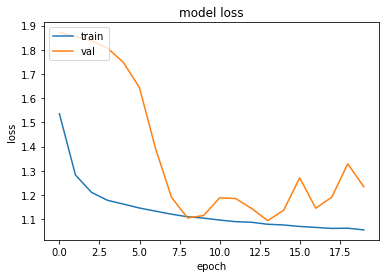

In [ ]:
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
#Evaluation and confusion matrix creation:
from sklearn.metrics import classification_report, confusion_matrix

x_test = np.asarray(list(map(lambda x: x[0], tfds.as_numpy(resized_ds_test_unbatched))))
y_test_orig = np.asarray(list(map(lambda x: x[1], tfds.as_numpy(resized_ds_test_unbatched))))

In [ ]:
predictions = model.predict(x_test)

96/96 [==============================] - 1s 3ms/step


In [ ]:
if loss!='sparse_categorical_crossentropy':
    false_arr = np.full(shape=len(class_list), fill_value = False)
    #y_pred = np.empty(shape=y_test_orig.shape[-1])
    i=0
    for i, pred in enumerate(predictions):
        temp_arr = copy.deepcopy(false_arr)
        np.put(temp_arr, np.argmax(pred), True)
    if i==0:
        y_pred = copy.deepcopy(temp_arr)
    else:
        y_pred = np.vstack([y_pred, temp_arr])
    display(y_pred.shape)
else:
    y_pred = np.argmax(predictions, axis=1)


In [ ]:
display(y_test_orig.shape)
display(y_pred.shape)

In [ ]:
print('Confusion Matrix')
if loss != 'sparse_categorical_crossentropy':
    matrix = confusion_matrix(y_test_orig.argmax(axis=1), y_pred.argmax(axis=1))
else:
    matrix = confusion_matrix(y_test_orig, y_pred)
display(matrix)

# Print Classification Report
print('Classification Report')
print(classification_report(y_test_orig, y_pred, target_names=class_names))

NOT using below things

In [ ]:
def ret_as_numpy():
    test = tfds.load(DataSet, split='test', as_supervised=True)
    test = prepare(test)
    test = tfds.as_numpy(test)
    return test

In [ ]:
test_as_np = ret_as_numpy()

In [ ]:
def evaluate_float_model(model, test):
    test_labels = []
    
    # Run predictions on every image in the "test" dataset.
    prediction_digits = []
    for i, test_example in enumerate(test):
        if i % 1000 == 0:
            print('Evaluated on {n} results so far.'.format(n=i))
        test_labels.append(np.argmax(test_example[-1]))
        test_image = test_example[0]
        # Pre-processing: add batch dimension and convert to float32 to match with
        # the model's input data format.
        #display(test_image.shape)
        test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
        #test_image = np.expand_dims(test_image, axis=3).astype(np.float32)
        #display(test_image.shape)
        
        # Run inference.
        output = model(test_image, training=False)
        # Post-processing: remove batch dimension and find the digit with highest
        # probability.
        output = output.numpy()
        #display(output[0])
        digit = np.argmax(output[0])
        prediction_digits.append(digit)
        
    print('\n')
    #display(output[0])
    #display(output)
    #display(digit)
    # Compare prediction results with ground truth labels to calculate accuracy.
    #display(prediction_digits)
    #display(test_labels)
    prediction_digits = np.array(prediction_digits)
    accuracy = (prediction_digits == test_labels).mean()
    return accuracy

In [ ]:
test_accuracy_Float = evaluate_float_model(model, test_as_np)

print('Float test_accuracy:', test_accuracy_Float)

Float checkpoint

In [ ]:
! pip install -q tensorflow-model-optimization
import tensorflow_model_optimization as tfmot
quantize_model = tfmot.quantization.keras.quantize_model

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.9/238.9 KB 7.0 MB/s eta 0:00:00


In [ ]:
q_aware_model = quantize_model(model)
q_aware_model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics=['accuracy'])
q_aware_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quantize_layer (QuantizeLay  (None, 60, 60, 3)        3         
 er)                                                             
                                                                 
 quant_conv2d (QuantizeWrapp  (None, 60, 60, 64)       4993      
 erV2)                                                           
                                                                 
 quant_batch_normalization (  (None, 60, 60, 64)       257       
 QuantizeWrapperV2)                                              
                                                                 
 quant_re_lu (QuantizeWrappe  (None, 60, 60, 64)       3         
 rV2)                                                            
                                                                 
 quant_max_pooling2d (Quanti  (None, 30, 30, 64)      

In [ ]:
quantize_train, quant_train_info = tfds.load(DataSet, split='train + test[:75%]', with_info=True, as_supervised=True)
filtered_quantize_train = quantize_train.filter(lambda x, y: filter_fn(y, class_list))

resized_quantize_train = prepare(filtered_quantize_train)

In [ ]:
resized_quantize_train = resized_quantize_train.batch(BATCH_SIZE)
h = q_aware_model.fit(resized_quantize_train, epochs=5, validation_data = resized_ds_test)

Epoch 1/5
21/21 [==============================] - 11s 452ms/step - loss: 93.8971 - accuracy: 0.6421 - val_loss: 92.0019 - val_accuracy: 0.7373
Epoch 2/5
21/21 [==============================] - 5s 263ms/step - loss: 90.5158 - accuracy: 0.6736 - val_loss: 89.0145 - val_accuracy: 0.7463
Epoch 3/5
21/21 [==============================] - 6s 278ms/step - loss: 87.7361 - accuracy: 0.7003 - val_loss: 86.6357 - val_accuracy: 0.7483
Epoch 4/5
21/21 [==============================] - 5s 261ms/step - loss: 85.5085 - accuracy: 0.7067 - val_loss: 84.6382 - val_accuracy: 0.7421
Epoch 5/5
21/21 [==============================] - 5s 258ms/step - loss: 83.5398 - accuracy: 0.7307 - val_loss: 82.8535 - val_accuracy: 0.7334


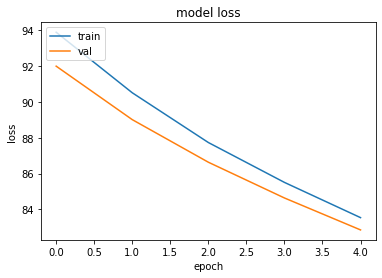

In [ ]:
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

quantized_tflite_model = converter.convert()

/usr/local/lib/python3.8/dist-packages/tensorflow/lite/python/convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


In [ ]:
def evaluate_model(interpreter, test):
    test_labels = []


    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]
    
    # Run predictions on every image in the "test" dataset.
    prediction_digits = []
    for i, test_example in enumerate(test):
        if i % 1000 == 0:
            print('Evaluated on {n} results so far.'.format(n=i))
        test_labels.append(np.argmax(test_example[-1]))
        test_image = test_example[0]
        # Pre-processing: add batch dimension and convert to float32 to match with
        # the model's input data format.
        #display(test_image.shape)
        test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
        #test_image = np.expand_dims(test_image, axis=3).astype(np.float32)
        #display(test_image.shape)
        interpreter.set_tensor(input_index, test_image)
        
        # Run inference.
        interpreter.invoke()
        
        # Post-processing: remove batch dimension and find the digit with highest
        # probability.
        output = interpreter.tensor(output_index)
        digit = np.argmax(output()[0])
        prediction_digits.append(digit)
        
    print('\n')
    # Compare prediction results with ground truth labels to calculate accuracy.
    prediction_digits = np.array(prediction_digits)
    accuracy = (prediction_digits == test_labels).mean()
    return accuracy

In [ ]:
#Models obtained from TfLiteConverter can be run in Python with Interpreter.
interpreter = tf.lite.Interpreter(model_content=quantized_tflite_model)
#Since TensorFlow Lite pre-plans tensor allocations to optimize inference, the user needs to call allocate_tensors() before any inference.
interpreter.allocate_tensors()

test_accuracy = evaluate_model(interpreter, test_as_np)

print('Quant TFLite test_accuracy:', test_accuracy)
#print('Quant TF test accuracy:', q_aware_model_accuracy)

Evaluated on 0 results so far.
Evaluated on 1000 results so far.
Evaluated on 2000 results so far.
Evaluated on 3000 results so far.
Evaluated on 4000 results so far.
Evaluated on 5000 results so far.
Evaluated on 6000 results so far.


Quant TFLite test_accuracy: 0.48520710059171596


In [ ]:
MODEL_DIR = "CadenceNet_Float"
model.save(MODEL_DIR, save_format="tf")

In [ ]:
!pip install -U tf2onnx==1.8.4
!python -m tf2onnx.convert --saved-model /content/CadenceNet_Float/ --output /content/CadenceNetOriginal_Float.onnx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.3/345.3 KB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 69.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 70.3 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.6
    Uninstalling protobuf-3.19.6:
      Successfully uninstalled protobuf-3.19.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.9.2 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.
tensorboard 2.9.1 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.
/usr/lib/python3.8/runpy.py:127: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onn

In [ ]:
quant_file = "/content/CadenceNetOriginal_QAT.tflite"
open(quant_file, "wb").write(quantized_tflite_model)

381680

In [ ]:

print("Float model in Mb: ", os.path.getsize("/content/CadenceNetOriginal_Float.onnx") / float(2**20))
print("Quantized model in Mb: ", os.path.getsize(quant_file) / float(2**20))
print("Float Model Accuracy: ", test_accuracy_Float)
print("Quantized Model Accuracy: ", test_accuracy)

Float model in Mb:  1.3894729614257812
Quantized model in Mb:  0.3639984130859375
Float Model Accuracy:  0.5046022353714661
Quantized Model Accuracy:  0.48520710059171596


In [ ]:
!pip install onnxruntime
import onnxruntime as rt

sess = rt.InferenceSession("/content/CadenceNetOriginal_Float.onnx")
input_name = sess.get_inputs()[0].name
output_name = sess.get_outputs()[0].name
x = np.random.random((1,IMG_SIZE,IMG_SIZE,NUM_CHANNELS))
x = x.astype(np.float32)
res = sess.run([output_name], {input_name: x})


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 46.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 KB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 KB 10.9 MB/s eta 0:00:00


In [ ]:
indices = tf.convert_to_tensor([0, 1, 2])
depth = 3
indic = tf.convert_to_tensor([3, 5, 8])
tf.math.multiply(indices, indic)

